<a href="https://www.kaggle.com/code/sevdanuropur/crm-rfm-cltv-prediction-analysis?scriptVersionId=168550774" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# CRM - RFM - CLTV PREDICTION ANALYSIS

# CONTENTS 
* Import Libraries & Loading Data
* Looking & Cleaning Data
* Calculating RFM Metrics
* Calculating RFM Scores
* Creating and Analyzing RFM Segments
* Visualization of RFM Segments
* BG-NBD and Gamma-Gamma with CLTV Forecast
* Preparation of Lifetime Data Structure
* Establishing the BG-NBD Model
* Evaluation of Estimation Results
* Establishing the GAMMA-GAMMA Model
* Calculation of CLTV with BG-NBD and GG model
* Creating Segments Based on CLTV
* Conlusion 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/coffee-bean-sales-raw-dataset/Raw Data.xlsx


# Import Libraries & Loading Data

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [3]:
df_orders = pd.read_excel("/kaggle/input/coffee-bean-sales-raw-dataset/Raw Data.xlsx", sheet_name="orders")

df_customer = pd.read_excel("/kaggle/input/coffee-bean-sales-raw-dataset/Raw Data.xlsx", sheet_name="customers")

df_products = pd.read_excel("/kaggle/input/coffee-bean-sales-raw-dataset/Raw Data.xlsx", sheet_name="products")

In [4]:
df_orders.head()

,Order ID,Order Date,Customer ID,Product ID,Quantity,Customer Name,Email,Country,Coffee Type,Roast Type,Size,Unit Price,Sales
0,QEV-37451-860,2019-09-05,17670-51384-MA,R-M-1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,QEV-37451-860,2019-09-05,17670-51384-MA,E-M-0.5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,FAA-43335-268,2021-06-17,21125-22134-PX,A-L-1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,KAC-83089-793,2021-07-15,23806-46781-OU,E-M-1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,KAC-83089-793,2021-07-15,23806-46781-OU,R-L-2.5,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# The last columns in df_orders are completely empty, let's delete them
dropped_columns = ["Customer Name", "Email", "Country", "Coffee Type", "Roast Type", "Size", "Unit Price", "Sales"]

df_orders.drop(dropped_columns, axis=1, inplace=True)

In [6]:
#  Let's merge df_orders and df_customer to get the features of customer 
df_2 = pd.merge(df_orders, df_customer, on="Customer ID")

In [7]:
# Lastly, we get the properties of the products by combining df_products.
df_k = pd.merge(df_2, df_products, on="Product ID")
df= df_k.copy()
df.head()

,Order ID,Order Date,Customer ID,Product ID,Quantity,Customer Name,Email,Phone Number,Address Line 1,City,Country,Postcode,Loyalty Card,Coffee Type,Roast Type,Size,Unit Price,Price per 100g,Profit
0,QEV-37451-860,2019-09-05,17670-51384-MA,R-M-1,2,Aloisia Allner,aallner0@lulu.com,+1 (862) 817-0124,57999 Pepper Wood Alley,Paterson,United States,7505,Yes,Rob,M,1.0000,9.9500,0.9950,0.5970
1,QEV-37451-860,2019-09-05,17670-51384-MA,E-M-0.5,5,Aloisia Allner,aallner0@lulu.com,+1 (862) 817-0124,57999 Pepper Wood Alley,Paterson,United States,7505,Yes,Exc,M,0.5000,8.2500,1.6500,0.9075
2,FAA-43335-268,2021-06-17,21125-22134-PX,A-L-1,1,Jami Redholes,jredholes2@tmall.com,+1 (210) 986-6806,5214 Bartillon Park,San Antonio,United States,78205,Yes,Ara,L,1.0000,12.9500,1.2950,1.1655
3,KAC-83089-793,2021-07-15,23806-46781-OU,E-M-1,2,Christoffer O' Shea,NaN,+353 (698) 362-9201,38980 Manitowish Junction,Cill Airne,Ireland,N41,No,Exc,M,1.0000,13.7500,1.3750,1.5125
4,KAC-83089-793,2021-07-15,23806-46781-OU,R-L-2.5,2,Christoffer O' Shea,NaN,+353 (698) 362-9201,38980 Manitowish Junction,Cill Airne,Ireland,N41,No,Rob,L,2.5000,27.4850,1.0994,1.6491


In [8]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

##################### Shape #####################
(1000, 19)
##################### Types #####################
Order ID                  object
Order Date        datetime64[ns]
Customer ID               object
Product ID                object
Quantity                   int64
Customer Name             object
Email                     object
Phone Number              object
Address Line 1            object
City                      object
Country                   object
Postcode                  object
Loyalty Card              object
Coffee Type               object
Roast Type                object
Size                     float64
Unit Price               float64
Price per 100g           float64
Profit                   float64
dtype: object
##################### NA #####################
Order ID            0
Order Date          0
Customer ID         0
Product ID          0
Quantity            0
Customer Name       0
Email             206
Phone Number      135
Address Line 1      0
Cit

In [9]:
# Since we know the IDs of the customers, we do not need to delete these lines. It makes more sense to fill them in instead.
df["Email"].fillna(0, inplace=True)
df["Phone Number"].fillna(0, inplace=True)

In [10]:
# ıt allows us to capture categorical columns
cat_cols = [col for col in df.columns if str(df[col].dtypes) in ["category", "object", "bool"]]

num_but_cat = [col for col in df.columns if
                   df[col].nunique() < 10 and df[col].dtypes in ["int64", "float64"]]

cat_but_car = [col for col in df.columns if
                   df[col].nunique() > 20 and str(df[col].dtypes) in ["category", "object"]]

cat_cols = cat_cols + num_but_cat
cat_cols = [col for col in cat_cols if col not in cat_but_car] 
cat_cols

['Country', 'Loyalty Card', 'Coffee Type', 'Roast Type', 'Quantity', 'Size']

In [11]:
# ıt allows us to capture numerical columns
num_cols = [col for col in df.columns if df[col].dtypes in ["int64", "float64"]]
num_cols = [col for col in num_cols if col not in cat_cols]
num_cols

['Unit Price', 'Price per 100g', 'Profit']

In [12]:
# Did a customer come only once?
df["Customer ID"].nunique()  
# means a customer has come more than once, there is multiplexing # 913 unique

913

In [13]:
df["Order ID"].nunique() 

957

In [14]:
# How many invoices has a customer created?

df.groupby("Customer ID").agg({"Order ID": "count"}).sort_values(by="Order ID", ascending=False).head()

,Order ID
Customer ID,
86579-92122-OC,7
16982-35708-BZ,5
66458-91190-YC,5
94091-86957-HX,5
62494-09113-RP,4


In [15]:
# How many invoices were generated by a customer on the same day?

df.groupby("Order Date").agg({"Order ID": "count"}).sort_values(by="Order ID", ascending=False).head()

,Order ID
Order Date,
2019-04-27,7
2019-01-02,5
2021-09-25,5
2021-05-23,5
2020-10-10,4


In [16]:
df.groupby(["Order ID", "Customer ID"]).agg({"Order Date": "count"}).sort_values(by="Order Date",
                                                                                 ascending=False).head()

,,Order Date
Order ID,Customer ID,
NOP-21394-646,16982-35708-BZ,5
NCH-55389-562,86579-92122-OC,4
PKN-19556-918,00445-42781-KX,4
CTE-31437-326,22721-63196-UJ,4
TKL-20738-660,47939-53158-LS,3


In [17]:
df.groupby("Customer ID").agg({"Order Date": "count"}).sort_values(by="Order Date", ascending=False).head()

,Order Date
Customer ID,
86579-92122-OC,7
16982-35708-BZ,5
66458-91190-YC,5
94091-86957-HX,5
62494-09113-RP,4


In [18]:
# this will give us the frequency of a customer
df.groupby("Customer ID").agg({"Order ID": "nunique"}).sort_values(by="Order ID", ascending=False).head()

,Order ID
Customer ID,
94091-86957-HX,5
66458-91190-YC,5
05325-97750-WP,4
86579-92122-OC,4
43439-94003-DW,4


In [19]:
# We need to multiply the two columns to find the price we received: price and amount

df["total_price"] = df["Quantity"] * df["Unit Price"]

In [20]:
# How much did a customer pay us in total? Top 10 customers

df.groupby("Customer ID").agg({"total_price": "sum"}).sort_values(by="total_price", ascending=False).head(10)

,total_price
Customer ID,
27930-59250-JT,317.0700
86579-92122-OC,307.0450
16880-78077-FB,289.1100
16982-35708-BZ,281.6750
19485-98072-PS,278.0100
57808-90533-UE,251.1250
01603-43789-TN,246.2100
72282-40594-RX,218.7300
27132-68907-RC,206.6000


In [21]:
# When was the last purchase made?
max_date = df["Order Date"].max() 
max_date

Timestamp('2022-08-19 00:00:00')

In [22]:
# 2022-08-19, let's add 2 days to this and do the analysis two days later.
from datetime import timedelta
today_date = max_date + timedelta(days=2)

# Calculating RFM Metrics

In [23]:
# now I need to calculate recency, frequency and monetary value

#recency means: analysis - last date the customer arrived: i.e. how long has there been no customer?

#frequency: How many times did a customer come to me, what is the frequency of coming to me?

#monetary: How much did the customer pay me?

# Since it is completely customer based, I need to put the customer in groupby

In [24]:
rfm = df.groupby("Customer ID").agg({"Order Date": lambda x: (today_date - x.max()).days,
                                     "Order ID": lambda y: y.nunique(),
                                     "total_price": lambda z: z.sum()})
rfm.head()

,Order Date,Order ID,total_price
Customer ID,,,
00246-15080-LE,40,1,178.7100
00256-19905-YG,1310,1,40.5000
00445-42781-KX,114,1,163.7200
00539-42510-RY,903,1,148.9250
00852-54571-WP,407,1,8.2500


In [25]:
# rename the column names 
rfm.columns = ["recency", "frequency", "monetary"]

# Calculating RFM Scores

In [26]:
# In order to make these metrics comparable, we need to be able to evaluate them all in the same scale.
rfm["recency_scre"] = pd.qcut(rfm["recency"], 5, labels=[5, 4, 3, 2, 1])

# It gives an error here because it assigns the same values to different labels, let's use the rank method to prevent this.
rfm["frequency_score"] = pd.qcut(rfm["frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

rfm["monetary_score"] = pd.qcut(rfm["monetary"], 5, labels=[1, 2, 3, 4, 5])

In [27]:
# To create the rfm score, we need frequency and recency values. I need to combine the two.
rfm["RFM_SCORE"] = rfm["recency_scre"].astype(str)+ rfm["frequency_score"].astype(str)

# Creating & Analysing RFM Segments

In [28]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions' # If you see the first element is five, the second element is 4 or 5
}

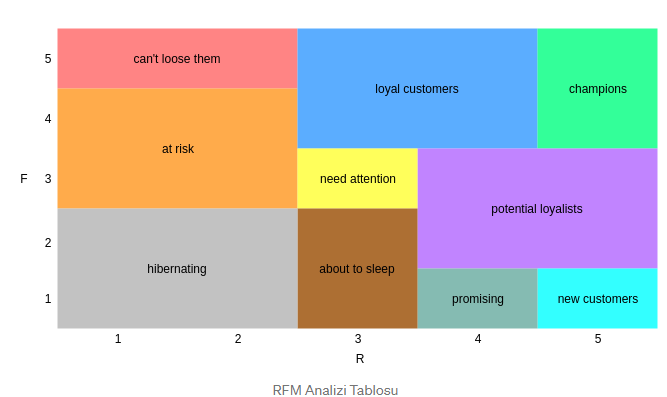

In [29]:
rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)

rfm.groupby("segment").agg({"recency": "mean",
                            "frequency": "mean",
                            "monetary":"mean"})

,recency,frequency,monetary
segment,,,
about_to_sleep,632.8472,1.0000,45.0566
at_Risk,1046.1656,1.0000,49.4064
cant_loose,1044.4237,1.0847,48.1836
champions,139.5714,1.2727,54.6788
hibernating,1044.6645,1.0000,48.1605
loyal_customers,502.5828,1.1192,49.6113
need_attention,606.1081,1.0000,50.6595
new_customers,129.4242,1.0000,61.9580
potential_loyalists,257.1143,1.0000,44.3480


In [30]:
selected=["segment","recency","frequency","monetary"]

rfm[["segment", "recency", "frequency", "monetary"]].groupby("segment").agg(["mean", "count"])

recency       frequency       monetary      
                         mean count      mean count     mean count
segment                                                           
about_to_sleep       632.8472    72    1.0000    72  45.0566    72
at_Risk             1046.1656   151    1.0000   151  49.4064   151
cant_loose          1044.4237    59    1.0847    59  48.1836    59
champions            139.5714    77    1.2727    77  54.6788    77
hibernating         1044.6645   155    1.0000   155  48.1605   155
loyal_customers      502.5828   151    1.1192   151  49.6113   151
need_attention       606.1081    37    1.0000    37  50.6595    37
new_customers        129.4242    33    1.0000    33  61.9580    33
potential_loyalists  257.1143   140    1.0000   140  44.3480   140
promising            387.8421    38    1.0000    38  60.3363    38

In [31]:
rfm[rfm["segment"]=="champions"].head(10)

,recency,frequency,monetary,recency_scre,frequency_score,monetary_score,RFM_SCORE,segment
Customer ID,,,,,,,,
16809-16936-WF,119,2,18.6900,5,5,2,55,champions
24972-55878-KX,232,3,141.7850,5,5,5,55,champions
27930-59250-JT,33,3,317.0700,5,5,5,55,champions
32743-78448-KT,158,2,162.1750,5,5,5,55,champions
52143-35672-JF,247,2,153.5350,5,5,5,55,champions
54798-14109-HC,191,3,46.8300,5,5,4,55,champions
57808-90533-UE,24,3,251.1250,5,5,5,55,champions
62494-09113-RP,76,3,90.6150,5,5,5,55,champions
63025-62939-AN,206,1,36.4500,5,4,3,54,champions


In [32]:
rfm[rfm["segment"]=="cant_loose"].head(10)

,recency,frequency,monetary,recency_scre,frequency_score,monetary_score,RFM_SCORE,segment
Customer ID,,,,,,,,
01035-70465-UO,1004,2,71.7000,2,5,4,25,cant_loose
01841-48191-NL,905,2,46.9650,2,5,4,25,cant_loose
04666-71569-RI,933,2,33.3100,2,5,3,25,cant_loose
37274-08534-FM,1012,2,37.9800,2,5,3,25,cant_loose
74330-29286-RO,843,2,193.6350,2,5,5,25,cant_loose
83731-53280-YC,897,1,29.8500,2,5,3,25,cant_loose
83737-56117-JE,945,1,59.7500,2,5,4,25,cant_loose
83844-95908-RX,1070,1,29.8500,1,5,3,15,cant_loose
84033-80762-EQ,801,1,155.2500,2,5,5,25,cant_loose


# Visualization of RFM Segments

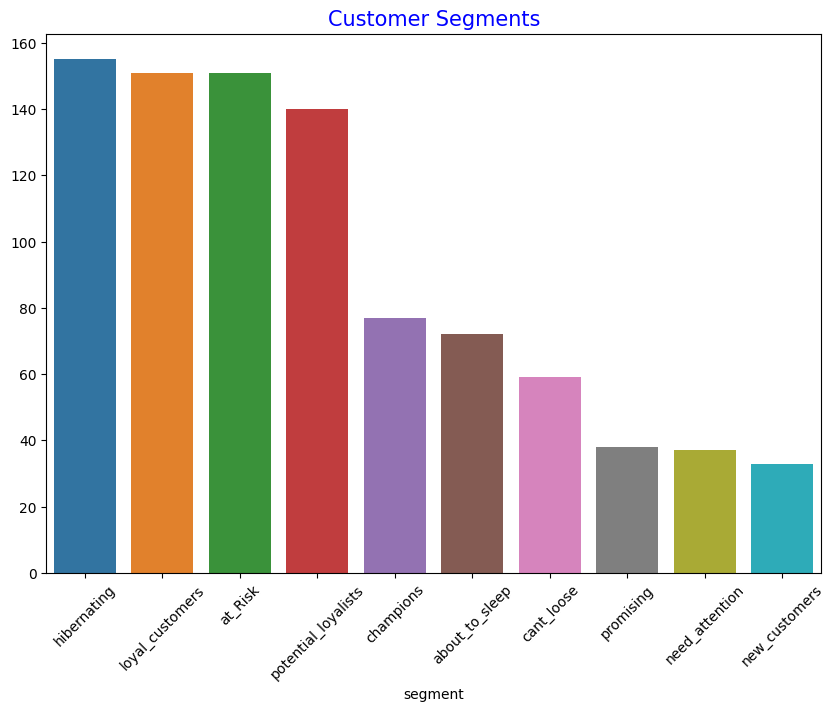

In [33]:
sgm= rfm["segment"].value_counts()
plt.figure(figsize=(10,7))
sns.barplot(x=sgm.index,y=sgm.values)
plt.xticks(rotation=45)
plt.title('Customer Segments',color = 'blue',fontsize=15)
plt.show()

#  BG-NBD and Gamma-Gamma with CLTV Prediction

In [34]:
pip install lifetimes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [35]:
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

In [36]:
df= df_k.copy()

In [37]:
# Let's check if there is an outlier or not.
num_cols

['Unit Price', 'Price per 100g', 'Profit']

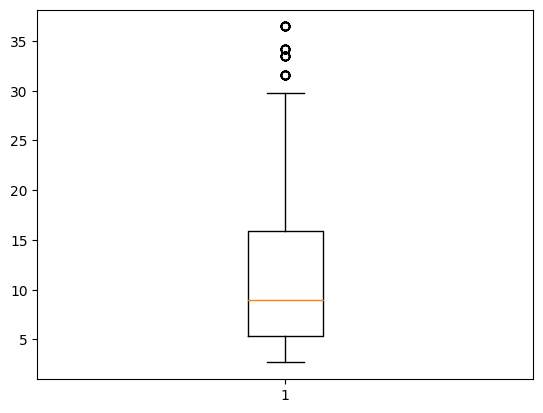

In [38]:
plt.boxplot(df["Unit Price"])
plt.show()

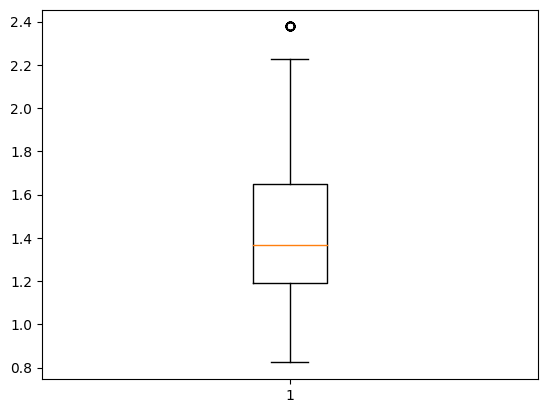

In [39]:
plt.boxplot(df["Price per 100g"])
plt.show()

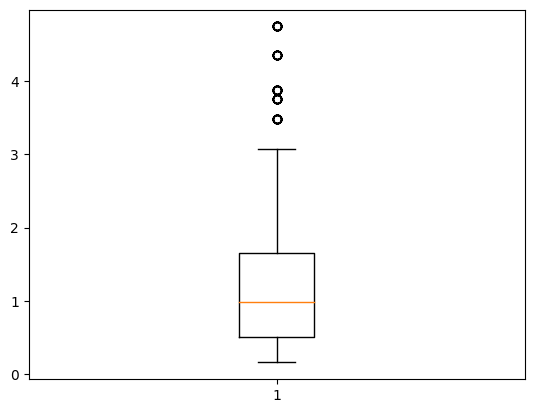

In [40]:
plt.boxplot(df["Profit"])
plt.show()

In [41]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.25)
    quartile3 = dataframe[variable].quantile(0.75)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [42]:
df["Email"].fillna(0, inplace=True)
df["Phone Number"].fillna(0, inplace=True) 

# Let's suppress the outliers with the suppression method
replace_with_thresholds(df, "Unit Price")
replace_with_thresholds(df, "Price per 100g")
replace_with_thresholds(df,"Profit")

df["total_price"] = df["Quantity"] * df["Unit Price"]
max_date = df["Order Date"].max()
from datetime import timedelta

today_date = max_date + timedelta(days=2)

# Preparation of Lifetime Data Structure

In [43]:
# recency: we will find each customer's own max and min dates (weekly) , substract them from each other 

# T: We will subtract the first date of arrival from the determined analysis date (weekly)

# frequency: total number of recurring purchases (frequency>1)

# monetary: average earnings per purchase # here it says average, we will divide the total earnings by frequency

In [44]:
cltv_df=df.groupby("Customer ID").agg({"Order Date":[lambda x: (x.max()-x.min()).days,
                                lambda y : (today_date-y.min()).days],
                               "Order ID": lambda z: z.nunique(),
                               "total_price": lambda k: k.sum()})
cltv_df.head()

Order Date            Order ID total_price
               <lambda_0> <lambda_1> <lambda>    <lambda>
Customer ID                                              
00246-15080-LE          0         40        1    178.7100
00256-19905-YG          0       1310        1     40.5000
00445-42781-KX          0        114        1    163.7200
00539-42510-RY          0        903        1    148.9250
00852-54571-WP          0        407        1      8.2500

In [45]:
cltv_df.columns = cltv_df.columns.droplevel(0) 

cltv_df.columns=['recency', 'T', 'frequency', 'monetary']

In [46]:
cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]
cltv_df = cltv_df[(cltv_df['frequency'] > 1)]
cltv_df["recency"] =cltv_df["recency"]/ 7
cltv_df["T"] = cltv_df["T"] / 7

 # Establishing the BG-NBD Model:
  ### here we are looking at the expected frequency

In [47]:
# Let's build the BG model and fit it
bgf = BetaGeoFitter(penalizer_coef=0.001) 
bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])

<lifetimes.BetaGeoFitter: fitted with 25 subjects, a: 1.08, alpha: 123.94, b: 4.55, r: 4.30>

In [48]:
# What are the expected purchases from customers in 1 week?
cltv_df["expected_purc_1_week"] = bgf.predict(1,  
                                              cltv_df['frequency'],
                                              cltv_df['recency'],
                                           cltv_df['T'])
cltv_df["expected_purc_1_week"].sort_values(ascending=False).head(10)

Customer ID
57808-90533-UE   0.0375
94091-86957-HX   0.0301
32743-78448-KT   0.0274
86579-92122-OC   0.0234
24972-55878-KX   0.0226
54798-14109-HC   0.0222
27930-59250-JT   0.0221
62494-09113-RP   0.0218
66458-91190-YC   0.0206
05325-97750-WP   0.0202
Name: expected_purc_1_week, dtype: float64

In [49]:
# What are the expected purchases from customers in 3 week?
cltv_df["expected_purc_3_week"]=bgf.predict(3,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T'])
cltv_df["expected_purc_3_week"].sort_values(ascending=False).head(10)

Customer ID
57808-90533-UE   0.1117
94091-86957-HX   0.0899
32743-78448-KT   0.0817
86579-92122-OC   0.0700
24972-55878-KX   0.0673
54798-14109-HC   0.0663
27930-59250-JT   0.0660
62494-09113-RP   0.0653
66458-91190-YC   0.0616
05325-97750-WP   0.0603
Name: expected_purc_3_week, dtype: float64

In [50]:
bgf.predict(4 * 3,# 3 months
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sort_values(ascending=False).head(10)

Customer ID
57808-90533-UE   0.4347
94091-86957-HX   0.3534
32743-78448-KT   0.3172
86579-92122-OC   0.2758
24972-55878-KX   0.2632
54798-14109-HC   0.2602
27930-59250-JT   0.2599
62494-09113-RP   0.2568
66458-91190-YC   0.2425
05325-97750-WP   0.2369
dtype: float64

In [51]:
bgf.predict(36,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sum()

13.410781057785577

# Evaluation of Prediction Results

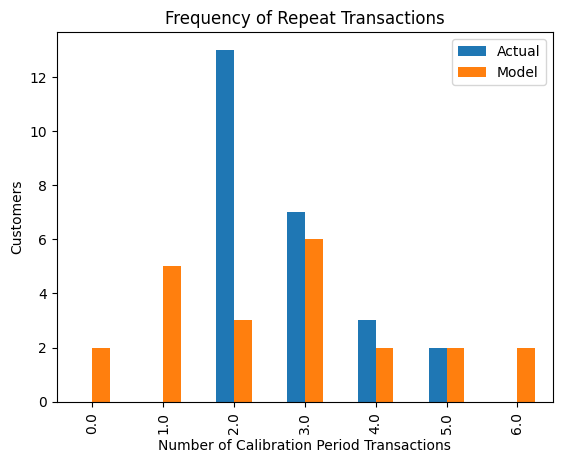

In [52]:
plot_period_transactions(bgf)
plt.show(block=True)

# Establishing the GAMMA-GAMMA Model

In [53]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

ggf.fit(cltv_df['frequency'], cltv_df['monetary'])

<lifetimes.GammaGammaFitter: fitted with 25 subjects, p: 3.96, q: 0.77, v: 3.78>

In [54]:
ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                        cltv_df['monetary']).sort_values(ascending=False).head(10)

Customer ID
27132-68907-RC   108.2540
27930-59250-JT   107.1494
74330-29286-RO   101.5191
16880-78077-FB    99.5765
19485-98072-PS    95.8027
57808-90533-UE    86.5690
32743-78448-KT    85.4842
52143-35672-JF    81.0337
86579-92122-OC    75.5832
65732-22589-OW    71.4915
dtype: float64

In [55]:
cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                             cltv_df['monetary'])
cltv_df["expected_average_profit"].sort_values(ascending=False).head(10)

Customer ID
27132-68907-RC   108.2540
27930-59250-JT   107.1494
74330-29286-RO   101.5191
16880-78077-FB    99.5765
19485-98072-PS    95.8027
57808-90533-UE    86.5690
32743-78448-KT    85.4842
52143-35672-JF    81.0337
86579-92122-OC    75.5832
65732-22589-OW    71.4915
Name: expected_average_profit, dtype: float64

# Calculation of CLTV with BG-NBD and GG model

In [56]:
cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=3,
                                   freq="W", # Frequency information of T.
                                   discount_rate=0.01)
cltv.head()

Customer ID
01035-70465-UO    0.4796
01841-48191-NL    0.4384
04666-71569-RI    0.2996
05325-97750-WP   11.0384
10142-55267-YO    1.3921
Name: clv, dtype: float64

In [57]:
cltv = cltv.reset_index()

# Let's see the clv value together with the values in the other dataframe.
cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")
cltv_final.head()
cltv_final.sort_values(by="clv", ascending=False).head(10)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_3_week,expected_average_profit,clv
16,57808-90533-UE,35.5714,39.0000,3,83.6167,0.0375,0.1117,86.5690,39.9584
10,27930-59250-JT,149.4286,154.1429,3,103.7950,0.0221,0.0660,107.1494,29.5976
11,32743-78448-KT,0.8571,23.4286,2,81.0875,0.0274,0.0817,85.4842,28.7812
23,86579-92122-OC,162.8571,173.1429,4,73.5300,0.0234,0.0700,75.5832,22.1597
7,19485-98072-PS,75.8571,130.7143,3,92.6700,0.0145,0.0435,95.8027,17.3879
14,52143-35672-JF,94.7143,130.0000,2,76.7675,0.0165,0.0494,81.0337,16.7144
6,16880-78077-FB,71.5714,132.5714,3,96.3700,0.0129,0.0387,99.5765,16.0833
9,27132-68907-RC,107.2857,167.1429,2,103.1900,0.0118,0.0353,108.2540,16.0154
18,65732-22589-OW,142.7143,163.8571,2,67.5050,0.0166,0.0497,71.4915,14.8821
8,24972-55878-KX,42.1429,75.2857,3,47.2617,0.0226,0.0673,49.4895,13.8356


# Creating Segments Based on CLTV

In [58]:
cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D", "C", "B", "A"])

cltv_final.sort_values(by="clv", ascending=False).head(50) 


,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_3_week,expected_average_profit,clv,segment
16,57808-90533-UE,35.5714,39.0000,3,83.6167,0.0375,0.1117,86.5690,39.9584,A
10,27930-59250-JT,149.4286,154.1429,3,103.7950,0.0221,0.0660,107.1494,29.5976,A
11,32743-78448-KT,0.8571,23.4286,2,81.0875,0.0274,0.0817,85.4842,28.7812,A
23,86579-92122-OC,162.8571,173.1429,4,73.5300,0.0234,0.0700,75.5832,22.1597,A
7,19485-98072-PS,75.8571,130.7143,3,92.6700,0.0145,0.0435,95.8027,17.3879,A
14,52143-35672-JF,94.7143,130.0000,2,76.7675,0.0165,0.0494,81.0337,16.7144,A
6,16880-78077-FB,71.5714,132.5714,3,96.3700,0.0129,0.0387,99.5765,16.0833,B
9,27132-68907-RC,107.2857,167.1429,2,103.1900,0.0118,0.0353,108.2540,16.0154,B
18,65732-22589-OW,142.7143,163.8571,2,67.5050,0.0166,0.0497,71.4915,14.8821,B
8,24972-55878-KX,42.1429,75.2857,3,47.2617,0.0226,0.0673,49.4895,13.8356,B


In [59]:
cltv_final.groupby("segment").agg({"recency":["count","mean","sum"],
                                   "T":["count","mean","sum"],
                                    "frequency":["count","mean","sum"],
                                     "monetary": ["count","mean","sum"],
                                      "clv":["count","mean","sum"]})

recency                      T                    frequency         \
          count    mean      sum count     mean       sum     count   mean   
segment                                                                      
D             7 47.3469 331.4286     7 144.7347 1013.1429         7 2.0000   
C             6 95.4762 572.8571     6 138.0476  828.2857         6 3.6667   
B             6 88.7619 532.5714     6 132.0000  792.0000         6 2.6667   
A             6 86.5476 519.2857     6 108.4048  650.4286         6 2.8333   

            monetary                    clv                   
        sum    count    mean      sum count    mean      sum  
segment                                                       
D        14        7 18.8868 132.2075     7  1.2020   8.4142  
C        22        6 39.7406 238.4435     6  7.3564  44.1381  
B        16        6 68.6472 411.8829     6 13.8581  83.1487  
A        17        6 85.2444 511.4667     6 25.7665 154.5991

# Conclusion

Hello again! It was really enjoyable for me to complete this work. I tried to concretize my analyzes on CRM Analytics with this data set. If you liked the work I did on this subject, I am waiting for your comments. If you have any bugs or improvement suggestions, please share. Also, if you have suggestions or topics you would like to include in my future projects, let me know. I look forward to your contributions and thank you! 🚀📈